
## Load and Visualize the Data

In [0]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

In [0]:
def get_data_loader(image_type, image_dir='sketch2face', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize((image_size,128)), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='face',batch_size=25)
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='sketch',batch_size=25)

## Display some Training Images


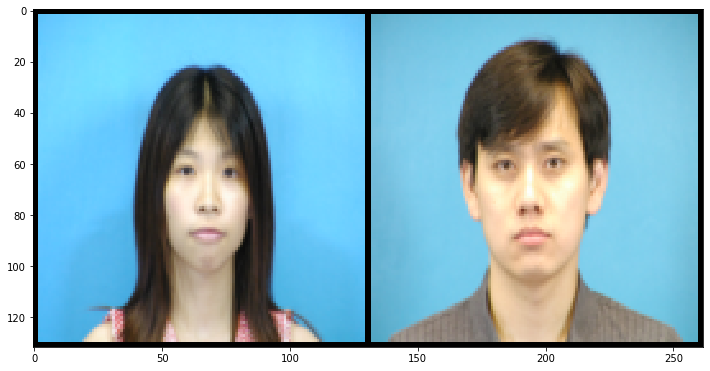

In [0]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

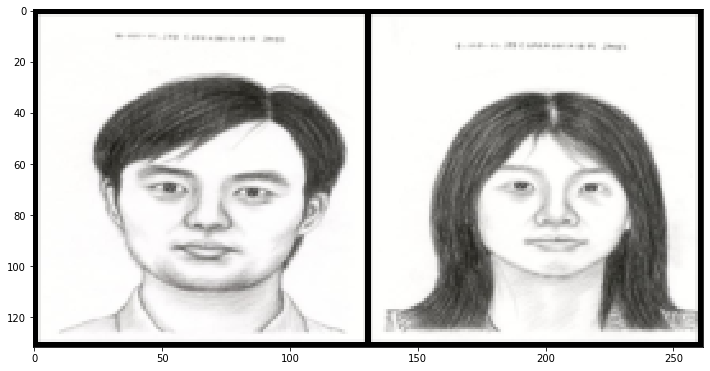

In [0]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [0]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0980)
Max:  tensor(1.)


In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.8039)
Scaled max:  tensor(1.)


---
## Define the Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### The Discriminator


In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

## Generators

Residual Block

In [0]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

### Transpose Convolutional Helper Function

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## The Generator 

In [0]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

---
Network

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [0]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

# pretrained weights will be used for further training and evaluating the model.
D_X.load_state_dict(torch.load('results/2.3/D_X.pth'))
G_XtoY.load_state_dict(torch.load('results/2.3/G_XtoY.pth'))
D_Y.load_state_dict(torch.load('results/2.3/D_Y.pth'))
G_YtoX.load_state_dict(torch.load('results/2.3/G_YtoX.pth'))

---
### Loss Functions



In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Optimizers


In [0]:
import torch.optim as optim

# hyperparams for Adam optimizer
#lr=0.0002
lr=0.00000001
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

# function to save weights

In [0]:
def save_weights():
    torch.save(D_X.state_dict(),'weights/D_X.pth')
    torch.save(G_XtoY.state_dict(),'weights/G_XtoY.pth')
    torch.save(D_Y.state_dict(),'weights/D_Y.pth')
    torch.save(G_YtoX.state_dict(),'weights/G_YtoX.pth')    

---

## Training a CycleGAN

In [0]:
# import save code
from helpers import save_samples, checkpoint

In [0]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        # Train with real images
        d_x_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images  
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
        
        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()


        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images
        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=5)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)
        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=5)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=25)
            G_YtoX.train()
            G_XtoY.train()
            save_weights()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=10006
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [0]:
n_epochs = 4000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.1346 | d_Y_loss: 0.0558 | g_total_loss: 2.3373
Epoch [   20/ 4000] | d_X_loss: 0.1345 | d_Y_loss: 0.0556 | g_total_loss: 2.3362
Epoch [   30/ 4000] | d_X_loss: 0.1344 | d_Y_loss: 0.0555 | g_total_loss: 2.3352
Epoch [   40/ 4000] | d_X_loss: 0.1343 | d_Y_loss: 0.0554 | g_total_loss: 2.3342
Epoch [   50/ 4000] | d_X_loss: 0.1341 | d_Y_loss: 0.0553 | g_total_loss: 2.3332
Epoch [   60/ 4000] | d_X_loss: 0.1340 | d_Y_loss: 0.0552 | g_total_loss: 2.3323
Epoch [   70/ 4000] | d_X_loss: 0.1339 | d_Y_loss: 0.0551 | g_total_loss: 2.3313
Epoch [   80/ 4000] | d_X_loss: 0.1338 | d_Y_loss: 0.0550 | g_total_loss: 2.3304
Epoch [   90/ 4000] | d_X_loss: 0.1337 | d_Y_loss: 0.0549 | g_total_loss: 2.3295
Epoch [  100/ 4000] | d_X_loss: 0.1336 | d_Y_loss: 0.0548 | g_total_loss: 2.3286


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000100-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.1334 | d_Y_loss: 0.0547 | g_total_loss: 2.3278
Epoch [  120/ 4000] | d_X_loss: 0.1333 | d_Y_loss: 0.0546 | g_total_loss: 2.3269
Epoch [  130/ 4000] | d_X_loss: 0.1332 | d_Y_loss: 0.0545 | g_total_loss: 2.3261
Epoch [  140/ 4000] | d_X_loss: 0.1331 | d_Y_loss: 0.0544 | g_total_loss: 2.3252
Epoch [  150/ 4000] | d_X_loss: 0.1330 | d_Y_loss: 0.0543 | g_total_loss: 2.3244
Epoch [  160/ 4000] | d_X_loss: 0.1329 | d_Y_loss: 0.0542 | g_total_loss: 2.3236
Epoch [  170/ 4000] | d_X_loss: 0.1328 | d_Y_loss: 0.0541 | g_total_loss: 2.3229
Epoch [  180/ 4000] | d_X_loss: 0.1326 | d_Y_loss: 0.0540 | g_total_loss: 2.3221
Epoch [  190/ 4000] | d_X_loss: 0.1325 | d_Y_loss: 0.0540 | g_total_loss: 2.3213
Epoch [  200/ 4000] | d_X_loss: 0.1324 | d_Y_loss: 0.0539 | g_total_loss: 2.3206


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000200-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.1323 | d_Y_loss: 0.0538 | g_total_loss: 2.3199
Epoch [  220/ 4000] | d_X_loss: 0.1322 | d_Y_loss: 0.0537 | g_total_loss: 2.3191
Epoch [  230/ 4000] | d_X_loss: 0.1321 | d_Y_loss: 0.0536 | g_total_loss: 2.3184
Epoch [  240/ 4000] | d_X_loss: 0.1320 | d_Y_loss: 0.0535 | g_total_loss: 2.3177
Epoch [  250/ 4000] | d_X_loss: 0.1319 | d_Y_loss: 0.0535 | g_total_loss: 2.3170
Epoch [  260/ 4000] | d_X_loss: 0.1318 | d_Y_loss: 0.0534 | g_total_loss: 2.3163
Epoch [  270/ 4000] | d_X_loss: 0.1316 | d_Y_loss: 0.0533 | g_total_loss: 2.3156
Epoch [  280/ 4000] | d_X_loss: 0.1315 | d_Y_loss: 0.0532 | g_total_loss: 2.3150
Epoch [  290/ 4000] | d_X_loss: 0.1314 | d_Y_loss: 0.0532 | g_total_loss: 2.3143
Epoch [  300/ 4000] | d_X_loss: 0.1313 | d_Y_loss: 0.0531 | g_total_loss: 2.3136


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000300-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.1312 | d_Y_loss: 0.0530 | g_total_loss: 2.3130
Epoch [  320/ 4000] | d_X_loss: 0.1311 | d_Y_loss: 0.0529 | g_total_loss: 2.3124
Epoch [  330/ 4000] | d_X_loss: 0.1310 | d_Y_loss: 0.0529 | g_total_loss: 2.3117
Epoch [  340/ 4000] | d_X_loss: 0.1309 | d_Y_loss: 0.0528 | g_total_loss: 2.3111
Epoch [  350/ 4000] | d_X_loss: 0.1308 | d_Y_loss: 0.0527 | g_total_loss: 2.3105
Epoch [  360/ 4000] | d_X_loss: 0.1307 | d_Y_loss: 0.0526 | g_total_loss: 2.3099
Epoch [  370/ 4000] | d_X_loss: 0.1306 | d_Y_loss: 0.0526 | g_total_loss: 2.3092
Epoch [  380/ 4000] | d_X_loss: 0.1305 | d_Y_loss: 0.0525 | g_total_loss: 2.3086
Epoch [  390/ 4000] | d_X_loss: 0.1304 | d_Y_loss: 0.0524 | g_total_loss: 2.3080
Epoch [  400/ 4000] | d_X_loss: 0.1303 | d_Y_loss: 0.0524 | g_total_loss: 2.3074


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000400-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.1302 | d_Y_loss: 0.0523 | g_total_loss: 2.3068
Epoch [  420/ 4000] | d_X_loss: 0.1301 | d_Y_loss: 0.0522 | g_total_loss: 2.3062
Epoch [  430/ 4000] | d_X_loss: 0.1300 | d_Y_loss: 0.0522 | g_total_loss: 2.3056
Epoch [  440/ 4000] | d_X_loss: 0.1299 | d_Y_loss: 0.0521 | g_total_loss: 2.3051
Epoch [  450/ 4000] | d_X_loss: 0.1298 | d_Y_loss: 0.0520 | g_total_loss: 2.3045
Epoch [  460/ 4000] | d_X_loss: 0.1297 | d_Y_loss: 0.0520 | g_total_loss: 2.3039
Epoch [  470/ 4000] | d_X_loss: 0.1296 | d_Y_loss: 0.0519 | g_total_loss: 2.3033
Epoch [  480/ 4000] | d_X_loss: 0.1295 | d_Y_loss: 0.0518 | g_total_loss: 2.3028
Epoch [  490/ 4000] | d_X_loss: 0.1294 | d_Y_loss: 0.0518 | g_total_loss: 2.3022
Epoch [  500/ 4000] | d_X_loss: 0.1293 | d_Y_loss: 0.0517 | g_total_loss: 2.3017


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000500-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.1292 | d_Y_loss: 0.0516 | g_total_loss: 2.3011
Epoch [  520/ 4000] | d_X_loss: 0.1291 | d_Y_loss: 0.0516 | g_total_loss: 2.3006
Epoch [  530/ 4000] | d_X_loss: 0.1290 | d_Y_loss: 0.0515 | g_total_loss: 2.3000
Epoch [  540/ 4000] | d_X_loss: 0.1289 | d_Y_loss: 0.0514 | g_total_loss: 2.2995
Epoch [  550/ 4000] | d_X_loss: 0.1288 | d_Y_loss: 0.0514 | g_total_loss: 2.2990
Epoch [  560/ 4000] | d_X_loss: 0.1287 | d_Y_loss: 0.0513 | g_total_loss: 2.2984
Epoch [  570/ 4000] | d_X_loss: 0.1286 | d_Y_loss: 0.0513 | g_total_loss: 2.2979
Epoch [  580/ 4000] | d_X_loss: 0.1285 | d_Y_loss: 0.0512 | g_total_loss: 2.2974
Epoch [  590/ 4000] | d_X_loss: 0.1284 | d_Y_loss: 0.0511 | g_total_loss: 2.2969
Epoch [  600/ 4000] | d_X_loss: 0.1283 | d_Y_loss: 0.0511 | g_total_loss: 2.2964


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.1282 | d_Y_loss: 0.0510 | g_total_loss: 2.2959
Epoch [  620/ 4000] | d_X_loss: 0.1282 | d_Y_loss: 0.0510 | g_total_loss: 2.2953
Epoch [  630/ 4000] | d_X_loss: 0.1281 | d_Y_loss: 0.0509 | g_total_loss: 2.2948
Epoch [  640/ 4000] | d_X_loss: 0.1280 | d_Y_loss: 0.0508 | g_total_loss: 2.2943
Epoch [  650/ 4000] | d_X_loss: 0.1279 | d_Y_loss: 0.0508 | g_total_loss: 2.2938
Epoch [  660/ 4000] | d_X_loss: 0.1278 | d_Y_loss: 0.0507 | g_total_loss: 2.2933
Epoch [  670/ 4000] | d_X_loss: 0.1277 | d_Y_loss: 0.0507 | g_total_loss: 2.2928
Epoch [  680/ 4000] | d_X_loss: 0.1276 | d_Y_loss: 0.0506 | g_total_loss: 2.2924
Epoch [  690/ 4000] | d_X_loss: 0.1275 | d_Y_loss: 0.0506 | g_total_loss: 2.2919
Epoch [  700/ 4000] | d_X_loss: 0.1274 | d_Y_loss: 0.0505 | g_total_loss: 2.2914


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000700-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.1273 | d_Y_loss: 0.0505 | g_total_loss: 2.2909
Epoch [  720/ 4000] | d_X_loss: 0.1272 | d_Y_loss: 0.0504 | g_total_loss: 2.2904
Epoch [  730/ 4000] | d_X_loss: 0.1271 | d_Y_loss: 0.0504 | g_total_loss: 2.2899
Epoch [  740/ 4000] | d_X_loss: 0.1270 | d_Y_loss: 0.0503 | g_total_loss: 2.2895
Epoch [  750/ 4000] | d_X_loss: 0.1269 | d_Y_loss: 0.0503 | g_total_loss: 2.2890
Epoch [  760/ 4000] | d_X_loss: 0.1269 | d_Y_loss: 0.0502 | g_total_loss: 2.2885
Epoch [  770/ 4000] | d_X_loss: 0.1268 | d_Y_loss: 0.0502 | g_total_loss: 2.2881
Epoch [  780/ 4000] | d_X_loss: 0.1267 | d_Y_loss: 0.0501 | g_total_loss: 2.2876
Epoch [  790/ 4000] | d_X_loss: 0.1266 | d_Y_loss: 0.0500 | g_total_loss: 2.2871
Epoch [  800/ 4000] | d_X_loss: 0.1265 | d_Y_loss: 0.0500 | g_total_loss: 2.2867


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000800-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.1264 | d_Y_loss: 0.0499 | g_total_loss: 2.2862
Epoch [  820/ 4000] | d_X_loss: 0.1263 | d_Y_loss: 0.0499 | g_total_loss: 2.2858
Epoch [  830/ 4000] | d_X_loss: 0.1262 | d_Y_loss: 0.0498 | g_total_loss: 2.2853
Epoch [  840/ 4000] | d_X_loss: 0.1261 | d_Y_loss: 0.0498 | g_total_loss: 2.2849
Epoch [  850/ 4000] | d_X_loss: 0.1261 | d_Y_loss: 0.0498 | g_total_loss: 2.2845
Epoch [  860/ 4000] | d_X_loss: 0.1260 | d_Y_loss: 0.0497 | g_total_loss: 2.2840
Epoch [  870/ 4000] | d_X_loss: 0.1259 | d_Y_loss: 0.0497 | g_total_loss: 2.2836
Epoch [  880/ 4000] | d_X_loss: 0.1258 | d_Y_loss: 0.0496 | g_total_loss: 2.2832
Epoch [  890/ 4000] | d_X_loss: 0.1257 | d_Y_loss: 0.0496 | g_total_loss: 2.2828
Epoch [  900/ 4000] | d_X_loss: 0.1256 | d_Y_loss: 0.0495 | g_total_loss: 2.2823


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000900-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.1255 | d_Y_loss: 0.0495 | g_total_loss: 2.2819
Epoch [  920/ 4000] | d_X_loss: 0.1254 | d_Y_loss: 0.0494 | g_total_loss: 2.2815
Epoch [  930/ 4000] | d_X_loss: 0.1254 | d_Y_loss: 0.0494 | g_total_loss: 2.2811
Epoch [  940/ 4000] | d_X_loss: 0.1253 | d_Y_loss: 0.0493 | g_total_loss: 2.2807
Epoch [  950/ 4000] | d_X_loss: 0.1252 | d_Y_loss: 0.0493 | g_total_loss: 2.2803
Epoch [  960/ 4000] | d_X_loss: 0.1251 | d_Y_loss: 0.0492 | g_total_loss: 2.2799
Epoch [  970/ 4000] | d_X_loss: 0.1250 | d_Y_loss: 0.0492 | g_total_loss: 2.2795
Epoch [  980/ 4000] | d_X_loss: 0.1249 | d_Y_loss: 0.0491 | g_total_loss: 2.2791
Epoch [  990/ 4000] | d_X_loss: 0.1248 | d_Y_loss: 0.0491 | g_total_loss: 2.2787
Epoch [ 1000/ 4000] | d_X_loss: 0.1248 | d_Y_loss: 0.0490 | g_total_loss: 2.2783


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001000-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.1247 | d_Y_loss: 0.0490 | g_total_loss: 2.2779
Epoch [ 1020/ 4000] | d_X_loss: 0.1246 | d_Y_loss: 0.0489 | g_total_loss: 2.2775
Epoch [ 1030/ 4000] | d_X_loss: 0.1245 | d_Y_loss: 0.0489 | g_total_loss: 2.2771
Epoch [ 1040/ 4000] | d_X_loss: 0.1244 | d_Y_loss: 0.0489 | g_total_loss: 2.2768
Epoch [ 1050/ 4000] | d_X_loss: 0.1243 | d_Y_loss: 0.0488 | g_total_loss: 2.2764
Epoch [ 1060/ 4000] | d_X_loss: 0.1242 | d_Y_loss: 0.0488 | g_total_loss: 2.2760
Epoch [ 1070/ 4000] | d_X_loss: 0.1242 | d_Y_loss: 0.0487 | g_total_loss: 2.2756
Epoch [ 1080/ 4000] | d_X_loss: 0.1241 | d_Y_loss: 0.0487 | g_total_loss: 2.2753
Epoch [ 1090/ 4000] | d_X_loss: 0.1240 | d_Y_loss: 0.0486 | g_total_loss: 2.2749
Epoch [ 1100/ 4000] | d_X_loss: 0.1239 | d_Y_loss: 0.0486 | g_total_loss: 2.2745


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001100-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.1238 | d_Y_loss: 0.0485 | g_total_loss: 2.2742
Epoch [ 1120/ 4000] | d_X_loss: 0.1237 | d_Y_loss: 0.0485 | g_total_loss: 2.2738
Epoch [ 1130/ 4000] | d_X_loss: 0.1236 | d_Y_loss: 0.0485 | g_total_loss: 2.2735
Epoch [ 1140/ 4000] | d_X_loss: 0.1235 | d_Y_loss: 0.0484 | g_total_loss: 2.2731
Epoch [ 1150/ 4000] | d_X_loss: 0.1235 | d_Y_loss: 0.0484 | g_total_loss: 2.2728
Epoch [ 1160/ 4000] | d_X_loss: 0.1234 | d_Y_loss: 0.0483 | g_total_loss: 2.2724
Epoch [ 1170/ 4000] | d_X_loss: 0.1233 | d_Y_loss: 0.0483 | g_total_loss: 2.2721
Epoch [ 1180/ 4000] | d_X_loss: 0.1232 | d_Y_loss: 0.0482 | g_total_loss: 2.2717
Epoch [ 1190/ 4000] | d_X_loss: 0.1231 | d_Y_loss: 0.0482 | g_total_loss: 2.2714
Epoch [ 1200/ 4000] | d_X_loss: 0.1230 | d_Y_loss: 0.0482 | g_total_loss: 2.2711


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001200-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.1229 | d_Y_loss: 0.0481 | g_total_loss: 2.2707
Epoch [ 1220/ 4000] | d_X_loss: 0.1229 | d_Y_loss: 0.0481 | g_total_loss: 2.2704
Epoch [ 1230/ 4000] | d_X_loss: 0.1228 | d_Y_loss: 0.0480 | g_total_loss: 2.2701
Epoch [ 1240/ 4000] | d_X_loss: 0.1227 | d_Y_loss: 0.0480 | g_total_loss: 2.2697
Epoch [ 1250/ 4000] | d_X_loss: 0.1226 | d_Y_loss: 0.0480 | g_total_loss: 2.2694
Epoch [ 1260/ 4000] | d_X_loss: 0.1225 | d_Y_loss: 0.0479 | g_total_loss: 2.2691
Epoch [ 1270/ 4000] | d_X_loss: 0.1224 | d_Y_loss: 0.0479 | g_total_loss: 2.2688
Epoch [ 1280/ 4000] | d_X_loss: 0.1223 | d_Y_loss: 0.0478 | g_total_loss: 2.2684
Epoch [ 1290/ 4000] | d_X_loss: 0.1223 | d_Y_loss: 0.0478 | g_total_loss: 2.2681
Epoch [ 1300/ 4000] | d_X_loss: 0.1222 | d_Y_loss: 0.0478 | g_total_loss: 2.2678


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001300-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.1221 | d_Y_loss: 0.0477 | g_total_loss: 2.2675
Epoch [ 1320/ 4000] | d_X_loss: 0.1220 | d_Y_loss: 0.0477 | g_total_loss: 2.2672
Epoch [ 1330/ 4000] | d_X_loss: 0.1219 | d_Y_loss: 0.0476 | g_total_loss: 2.2669
Epoch [ 1340/ 4000] | d_X_loss: 0.1218 | d_Y_loss: 0.0476 | g_total_loss: 2.2666
Epoch [ 1350/ 4000] | d_X_loss: 0.1217 | d_Y_loss: 0.0476 | g_total_loss: 2.2663
Epoch [ 1360/ 4000] | d_X_loss: 0.1217 | d_Y_loss: 0.0475 | g_total_loss: 2.2660
Epoch [ 1370/ 4000] | d_X_loss: 0.1216 | d_Y_loss: 0.0475 | g_total_loss: 2.2657
Epoch [ 1380/ 4000] | d_X_loss: 0.1215 | d_Y_loss: 0.0474 | g_total_loss: 2.2654
Epoch [ 1390/ 4000] | d_X_loss: 0.1214 | d_Y_loss: 0.0474 | g_total_loss: 2.2651
Epoch [ 1400/ 4000] | d_X_loss: 0.1213 | d_Y_loss: 0.0473 | g_total_loss: 2.2649


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001400-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.1212 | d_Y_loss: 0.0473 | g_total_loss: 2.2646
Epoch [ 1420/ 4000] | d_X_loss: 0.1211 | d_Y_loss: 0.0473 | g_total_loss: 2.2643
Epoch [ 1430/ 4000] | d_X_loss: 0.1210 | d_Y_loss: 0.0472 | g_total_loss: 2.2640
Epoch [ 1440/ 4000] | d_X_loss: 0.1210 | d_Y_loss: 0.0472 | g_total_loss: 2.2637
Epoch [ 1450/ 4000] | d_X_loss: 0.1209 | d_Y_loss: 0.0472 | g_total_loss: 2.2635
Epoch [ 1460/ 4000] | d_X_loss: 0.1208 | d_Y_loss: 0.0471 | g_total_loss: 2.2632
Epoch [ 1470/ 4000] | d_X_loss: 0.1207 | d_Y_loss: 0.0471 | g_total_loss: 2.2629
Epoch [ 1480/ 4000] | d_X_loss: 0.1206 | d_Y_loss: 0.0470 | g_total_loss: 2.2626
Epoch [ 1490/ 4000] | d_X_loss: 0.1205 | d_Y_loss: 0.0470 | g_total_loss: 2.2624
Epoch [ 1500/ 4000] | d_X_loss: 0.1204 | d_Y_loss: 0.0470 | g_total_loss: 2.2621


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001500-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.1204 | d_Y_loss: 0.0469 | g_total_loss: 2.2619
Epoch [ 1520/ 4000] | d_X_loss: 0.1203 | d_Y_loss: 0.0469 | g_total_loss: 2.2616
Epoch [ 1530/ 4000] | d_X_loss: 0.1202 | d_Y_loss: 0.0469 | g_total_loss: 2.2614
Epoch [ 1540/ 4000] | d_X_loss: 0.1201 | d_Y_loss: 0.0468 | g_total_loss: 2.2611
Epoch [ 1550/ 4000] | d_X_loss: 0.1200 | d_Y_loss: 0.0468 | g_total_loss: 2.2609
Epoch [ 1560/ 4000] | d_X_loss: 0.1199 | d_Y_loss: 0.0468 | g_total_loss: 2.2606
Epoch [ 1570/ 4000] | d_X_loss: 0.1198 | d_Y_loss: 0.0467 | g_total_loss: 2.2604
Epoch [ 1580/ 4000] | d_X_loss: 0.1197 | d_Y_loss: 0.0467 | g_total_loss: 2.2601


KeyboardInterrupt: 

In [0]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!


In [0]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


In [0]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

In [0]:
# view samples at iteration 4000
view_samples(4000, 'samples_cyclegan')